## Подготовка данных

1) Стоимость Brent - в источник из задания есть сразу csv-файлы по дням и по годам 

2) Курсы рубля - извлечь из xml по ссылке http://www.cbr.ru/scripts/XML_dynamic.asp?date_req1=01/01/2000&date_req2=31/12/2021&VAL_NM_RQ=R01235

3) Инфляция рубля по годам - из источника в задании легко извлечь 
csv-файл

In [1]:
from functools import reduce

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import xml.etree.ElementTree as ET

sns.set_theme()
%matplotlib inline

# Данные с сайта cbr.ru
PATH_RATES = 'rates.xml'
# данные с сайта https://data.oecd.org/price/inflation-cpi.htm
PATH_CPI = 'cpi.csv'
# Файл данных с https://datahub.io/core/oil-prices#resource-brent-daily
PATH_BRENT = 'brent-daily.csv'


# функция для извлечения курсов рубля к доллару из xml-формата с сайта Банка России
def extract_rates(path):
    """Возвращает список туплов [('дата', 'курс'), ...]."""
    tree = ET.parse(path)
    root = tree.getroot()

    rates = []
    for child in root:
        rates.append((child.attrib['Date'], child[1].text))
    
    return rates

# извлечение курсов и укладывание данных в DataFrame
rates_df = pd.DataFrame(extract_rates(PATH_RATES), columns=['date', 'rate'])

# замена десятичной запятой на английскую десятичную точку в курсе валюты
rates_df['rate'] = rates_df['rate'].str.replace(',', '.').astype('float')
# преобразование даты в формат datetime
rates_df['date'] = pd.to_datetime(rates_df['date'], format='%d.%m.%Y')

In [2]:
print(rates_df.dtypes, rates_df.shape, '\n')
print(rates_df.head(3))
print(rates_df.tail(3))

date    datetime64[ns]
rate           float64
dtype: object (5403, 2) 

        date   rate
0 2000-01-01  27.00
1 2000-01-06  26.90
2 2000-01-07  27.23
           date     rate
5400 2021-10-07  72.5682
5401 2021-10-08  72.2854
5402 2021-10-09  71.9882


In [3]:
# код для объединения данных по нефти Brent и данных по курсу рубля
brent_daily = pd.read_csv(PATH_BRENT)

# Конвертация даты в формат datetime
brent_daily['Date'] = pd.to_datetime(brent_daily['Date'])

# Пересечение двух датафреймов по дате
rates_brent = rates_df.merge(
    brent_daily,
    left_on='date',
    right_on='Date',
    how='inner'
    )
# Удалить лишнюю колонку с датами
rates_brent = rates_brent.drop(['Date'], axis=1)
# Переименовать название переменной Price в price_usd
rates_brent = rates_brent.rename(columns={'Price': 'price_usd'})
# Добавить колонку с ценами Brent в рублях
rates_brent['price_rub'] = rates_brent['rate'] * rates_brent['price_usd']

print(rates_brent.shape)
print(rates_brent.head(3))
print(rates_brent.tail(3))

# Группировка данных по годам
rates_brent_yearly = rates_brent.groupby(
    rates_brent['date'].dt.year
    )[['rate', 'price_usd', 'price_rub']].mean()

# Индекс в datetime
rates_brent_yearly.index = pd.to_datetime(
    rates_brent_yearly.index, format='%Y'
    ).year

rates_brent_yearly.head()

(4014, 4)
        date   rate  price_usd  price_rub
0 2000-01-06  26.90      23.55   633.4950
1 2000-01-07  27.23      23.35   635.8205
2 2000-01-11  27.73      23.93   663.5789
           date     rate  price_usd    price_rub
4011 2020-08-26  74.5126      45.79  3411.931954
4012 2020-08-27  75.5379      44.84  3387.119436
4013 2020-08-28  75.2354      45.22  3402.144788


,rate,price_usd,price_rub
date,,,
2000,28.130722,28.671443,805.978665
2001,29.168821,24.445333,711.963184
2002,31.367299,25.056041,786.817534
2003,30.671455,28.811307,883.941875
2004,28.804391,38.433317,1107.719998


## Корреляция курса рубля / стоимости нефти в рублях по годам в номинальных ценах

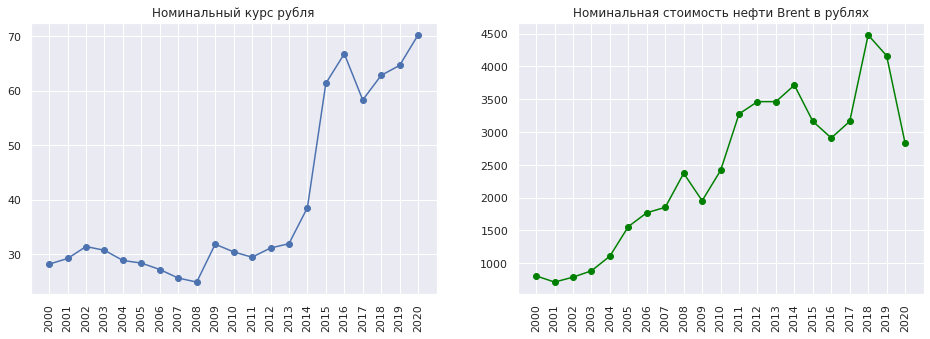

In [4]:
# Чтобы уместить курсы рубля и стоимость нефти на одном графике,
# данные нужно прообразовать. Без этого можно только на двух графиках,
# как показано ниже
fig, (ax1, ax2)  = plt.subplots(1, 2)

ax1.plot(rates_brent_yearly['rate'], marker='o')
ax1.xaxis.set_tick_params(rotation=90)
ax1.set_title('Номинальный курс рубля')


ax2.plot(rates_brent_yearly['price_rub'], marker='o', color='green')
ax2.xaxis.set_tick_params(rotation=90)
ax2.set_title('Номинальная стоимость нефти Brent в рублях')

ax1.set_xticks(rates_brent_yearly.index)
ax2.set_xticks(rates_brent_yearly.index)

fig.set_size_inches(16, 5)

plt.show()

# Проблема в том, что по оси Y разный масштаб цифр

## Использование лог. шкалы для цен, чтобы все уместить на 1 график

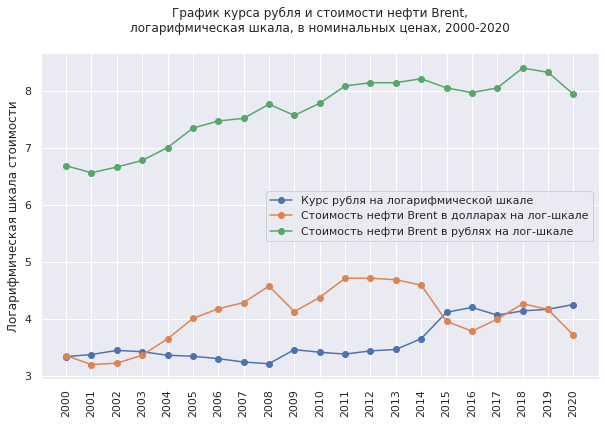

In [5]:
# Применить лог ко всему DataFrame
log_rates_brent_yearly = rates_brent_yearly.apply(np.log, axis=1)

# построение графика
fig, ax = plt.subplots()

ax.plot(log_rates_brent_yearly, marker='o')

title = """График курса рубля и стоимости нефти Brent,
логарифмическая шкала, в номинальных ценах, 2000-2020
"""
ax.set_title(title)

ax.xaxis.set_tick_params(rotation=90)
ax.set_xticks(log_rates_brent_yearly.index)
ax.set_ylabel('Логарифмическая шкала стоимости')

fig.set_size_inches(10, 6)

labels = ['Курс рубля на логарифмической шкале', 
          'Стоимость нефти Brent в долларах на лог-шкале',
          'Стоимость нефти Brent в рублях на лог-шкале'
          ]
plt.legend(loc='best', labels=labels)
plt.show()

# Логарифмическая шкала для цен. В принципе, можно было бы использовать
# лог-шкалу, по ней вроде бы виден характер связи цен на нефть и курса рубля,
# но тут лучше использовать цену в долларах, так как разница в диапазоне лог-цен
# для стоимости в рублях все же остается слишком большой и кривые неудобно сравнивать

## Min-max- скалирование цен, чтобы уместить их в один диапазон

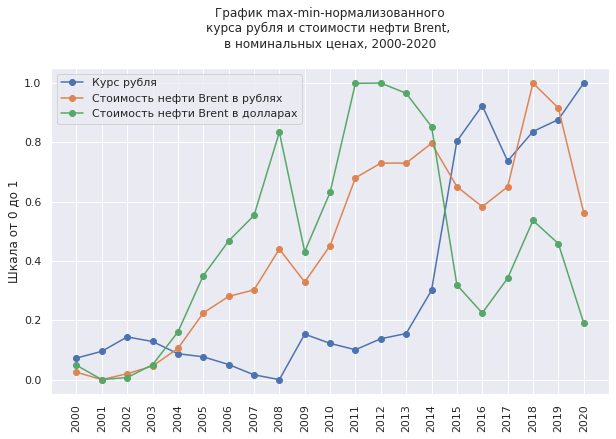

In [6]:
# Min-Max-нормализация данных -- скалирует данные к диапазону [0, 1] 
d1 = rates_brent_yearly['rate']
d2 = rates_brent_yearly['price_rub']
d3 = rates_brent_yearly['price_usd']
rates_norm = (d1 - np.min(d1))/(np.max(d1) - np.min(d1))
brent_rub_norm = (d2 - np.min(d2))/(np.max(d2) - np.min(d2))
brent_usd_norm = (d3 - np.min(d3))/(np.max(d3) - np.min(d3))

data = np.array([rates_norm, brent_rub_norm, brent_usd_norm]).T

norm_df = pd.DataFrame(data=data, index=rates_brent_yearly.index)

# Построение графика
fig, ax = plt.subplots()

ax.plot(norm_df, marker='o')

title = """График max-min-нормализованного
курса рубля и стоимости нефти Brent, 
в номинальных ценах, 2000-2020
"""
ax.set_title(title)
ax.xaxis.set_tick_params(rotation=90)
ax.set_xticks(norm_df.index)
ax.set_ylabel('Шкала от 0 до 1')

fig.set_size_inches(10, 6)

labels=['Курс рубля',
        'Стоимость нефти Brent в рублях', 
        'Стоимость нефти Brent в долларах'
        ]
plt.legend(loc='best', labels=labels)
plt.show()

В целом, на первый взгляд согласно графику курс рубля обратно пропорционален ценам на нефть. Из заметных тенденций, в 2002-2008 гг. рубль укрепляется, стимулируемый притоком валюты из-за роста цен на нефть. В 2014-2015 гг. резкое обесценение рубля на фоне обвала цен на нефть, причем обвал цен более выражен на кривой в долларах

### Среднеквадратичные отклонения

In [7]:
# Среднеквадратичные отклонения 3-х переменных по годам
rates_brent_yearly_std = rates_brent.groupby(
    rates_brent['date'].dt.year
    )[['rate', 'price_usd', 'price_rub']].std()
rates_brent_yearly_std.head(2)

,rate,price_usd,price_rub
date,,,
2000,0.375177,3.424541,91.853289
2001,0.481345,3.358195,91.549071


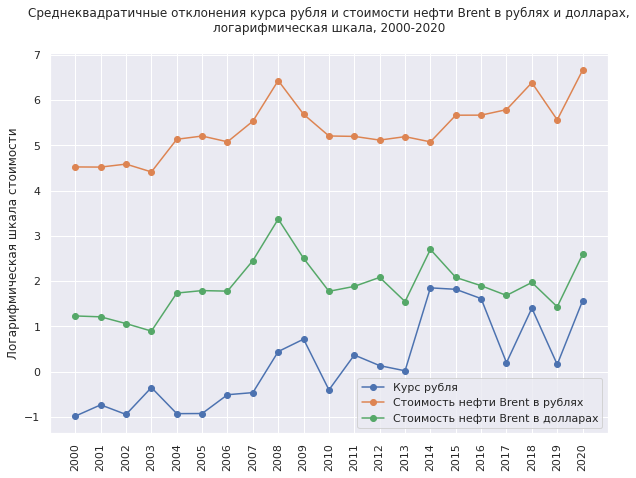

In [8]:
# Логарифмическая шкала
log_rate_rub = np.log(rates_brent_yearly_std['rate'])
log_brent_rub = np.log(rates_brent_yearly_std['price_rub'])
log_brent_usd = np.log(rates_brent_yearly_std['price_usd'])

fig, ax = plt.subplots()

# График лог-курса рубля
ax.plot(
    log_rate_rub, 
    label='Курс рубля',
    marker='o'
    )

# График лог-стоимости Brent  в рублях
ax.plot(
    log_brent_rub, 
    label='Стоимость нефти Brent в рублях',
    marker='o'
    )

title = """Среднеквадратичные отклонения курса рубля и стоимости нефти Brent в рублях и долларах,
логарифмическая шкала, 2000-2020
"""
# График лог-стоимости Brent в долларах 
ax.plot(
    log_brent_usd, 
    label='Стоимость нефти Brent в долларах',
    marker='o'
    )

ax.set_title(title)

ax.xaxis.set_tick_params(rotation=90)
ax.set_xticks(np.arange(2000, 2021, 1))
ax.set_ylabel('Логарифмическая шкала стоимости')

fig.set_size_inches(10, 7)

plt.legend(loc='best')
plt.show()

### Min-max- скалирование среднеквадратичных отклонений

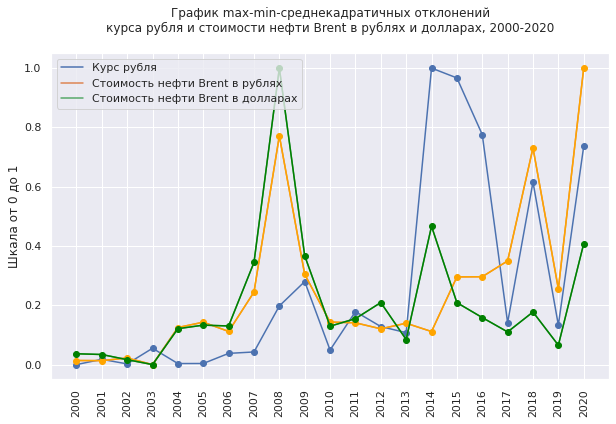

In [9]:
# Min-Max-нормализация данных -- скалирует данные к диапазону [0, 1] 
d1 = rates_brent_yearly_std['rate']
d2 = rates_brent_yearly_std['price_rub']
d3 = rates_brent_yearly_std['price_usd']
rates_normalized_std = (d1 - np.min(d1))/(np.max(d1) - np.min(d1))
brent_normalized_std = (d2 - np.min(d2))/(np.max(d2) - np.min(d2))
brent_usd_normalized_std = (d3 - np.min(d3))/(np.max(d3) - np.min(d3))

fig, ax = plt.subplots()

# График нормализованного курса рубля
ax.plot(
    rates_normalized_std, 
    label='Курс рубля',
    )
ax.plot(rates_normalized_std, 'bo')

# График нормализованной стоимости Brent в рублях
ax.plot(
    brent_normalized_std, 
    label='Стоимость нефти Brent в рублях',
    )
ax.plot(brent_normalized_std, marker='o', color='orange')

title = """График max-min-среднекадратичных отклонений
курса рубля и стоимости нефти Brent в рублях и долларах, 2000-2020
"""
# График нормализованной стоимости Brent в долларах 
ax.plot(
    brent_usd_normalized_std, 
    label='Стоимость нефти Brent в долларах'
    )
ax.plot(brent_usd_normalized_std, marker='o', color='green')

ax.set_title(title)

ax.xaxis.set_tick_params(rotation=90)
ax.set_xticks(np.arange(2000, 2021, 1))
ax.set_ylabel('Шкала от 0 до 1')

fig.set_size_inches(10, 6)

plt.legend(loc='best')
plt.show()

Вывод:
Во-первых, сильный разброс значений на графике говорит о нестабильности цен на нефть. 
Во-вторых, кривые среднеквадратичных отклонений курса рубля и стоимости нефти в долларах с 2004 года имеют схожую динамику. Пики и спады практически во всех точках совпадают, отличается только диапазон разброса, что говорит об определенной зависимости этих переменных, но не полной. На динамику значений также влияет экономическая и политическая ситуация в стране и в мире. 
2008-2009 гг. - обвал цен на нефть на фоне мирового финансового кризиса. 
2014-2015 гг. - активная фаза введения санкций против России в целом и нефтегазовой отрасли в частности в связи с ситуацией с Крымом. 
2018 г. - новые санкции против России, эскалация ближневосточного конфликта.

### Доверительный интервал (3 сигмы)

In [10]:
# Cчитаем доверительный интервал в пределах 3-х сигм по 3-м переменным из rates_brent 
# по формуле [x.mean() - 3 * x.std(), x.mean() + 3 * x.std()])
price_rub_sigma = [rates_brent['price_rub'].mean() - 3 * rates_brent['price_rub'].std(), rates_brent['price_rub'].mean() + 3 * rates_brent['price_rub'].std()]
print(price_rub_sigma)
price_usd_sigma = [rates_brent['price_usd'].mean() - 3 * rates_brent['price_usd'].std(), rates_brent['price_usd'].mean() + 3 * rates_brent['price_usd'].std()]
print(price_usd_sigma)
rate_sigma = [rates_brent['rate'].mean() - 3 * rates_brent['rate'].std(), rates_brent['rate'].mean() + 3 * rates_brent['rate'].std()]
print(rate_sigma)

[-1162.332479654338, 5977.712362528768]
[-25.831980145455987, 153.39391337913835]
[-7.881833097985279, 85.93763613734747]


In [11]:
# Добавляем нижнее и верхнее значения доверительного интервала в копию rates_brent 
rates_brent2 = rates_brent.copy() 
rates_brent2['price_rub_sigma_low'] = -1162 
rates_brent2['price_rub_sigma_high'] = 5978
rates_brent2['price_usd_sigma_low'] = -26 
rates_brent2['price_usd_sigma_high'] = 153
rates_brent2['rate_sigma_low'] = -8
rates_brent2['rate_sigma_high'] = 86
rates_brent2.head(2)

,date,rate,price_usd,price_rub,price_rub_sigma_low,price_rub_sigma_high,price_usd_sigma_low,price_usd_sigma_high,rate_sigma_low,rate_sigma_high
0,2000-01-06,26.90,23.55,633.4950,-1162,5978,-26,153,-8,86
1,2000-01-07,27.23,23.35,635.8205,-1162,5978,-26,153,-8,86


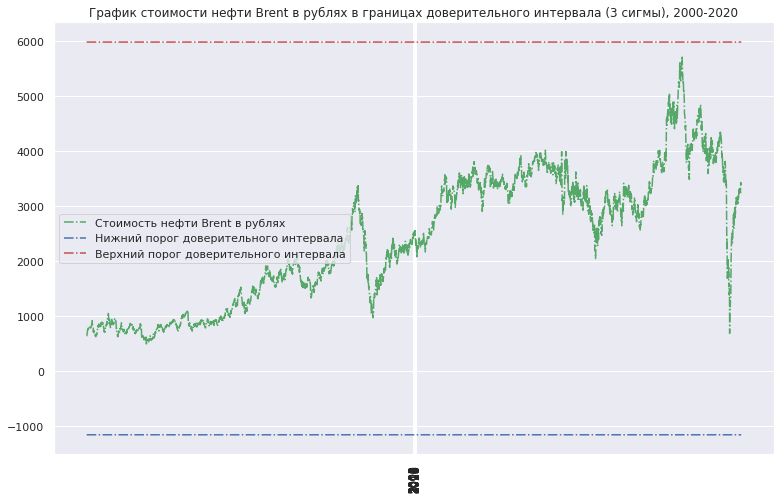

In [12]:
# Строим график
price_rub = rates_brent2['price_rub']
sigma_low = rates_brent2['price_rub_sigma_low']
sigma_high = rates_brent2['price_rub_sigma_high']
fig = plt.figure(figsize=(10, 6))
axes = fig.add_axes([0, 0, 1, 1])
plt.plot(price_rub, "g-.", label='Стоимость нефти Brent в рублях')
plt.plot(sigma_low, "b-.", label='Нижний порог доверительного интервала')
plt.plot(sigma_high, "r-.", label='Верхний порог доверительного интервала')
axes.set_xticks(np.arange(2000, 2021, 1)) 
axes.xaxis.set_tick_params(rotation=90)
title = """График стоимости нефти Brent в рублях в границах доверительного интервала (3 сигмы), 2000-2020"""
axes.set_title(title)
plt.legend()
plt.show()

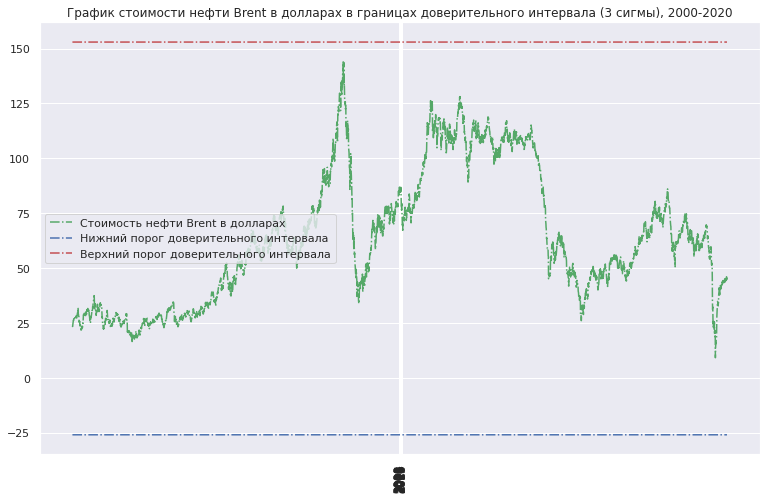

In [13]:
price_usd = rates_brent2['price_usd']
price_usd_sigma_low = rates_brent2['price_usd_sigma_low']
price_usd_sigma_high = rates_brent2['price_usd_sigma_high']
fig = plt.figure(figsize=(10, 6))
axes = fig.add_axes([0, 0, 1, 1])
plt.plot(price_usd, "g-.", label='Стоимость нефти Brent в долларах')
plt.plot(price_usd_sigma_low, "b-.", label='Нижний порог доверительного интервала')
plt.plot(price_usd_sigma_high, "r-.", label='Верхний порог доверительного интервала')
axes.set_xticks(np.arange(2000, 2021, 1))
axes.xaxis.set_tick_params(rotation=90)
title = """График стоимости нефти Brent в долларах в границах доверительного интервала (3 сигмы), 2000-2020"""
axes.set_title(title)
plt.legend()
plt.show()

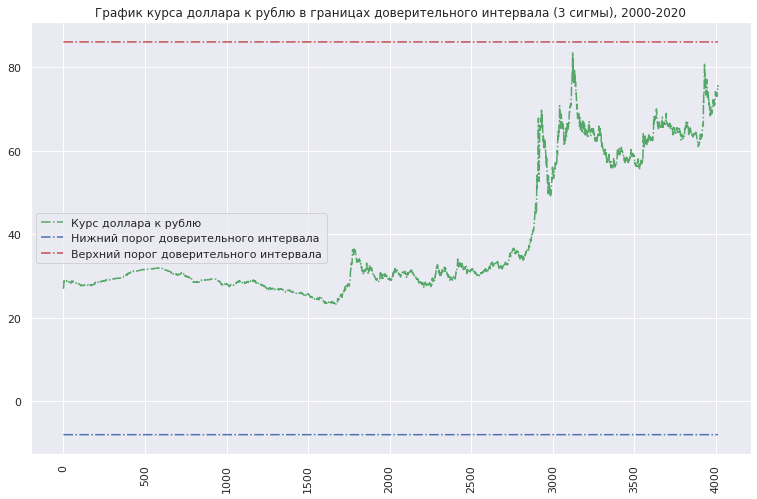

In [34]:
rate = rates_brent2['rate']
sigma_low = rates_brent2['rate_sigma_low']
sigma_high = rates_brent2['rate_sigma_high']
fig = plt.figure(figsize=(10, 6))
axes = fig.add_axes([0, 0, 1, 1])
plt.plot(rate, "g-.", label='Курс доллара к рублю')
plt.plot(sigma_low, "b-.", label='Нижний порог доверительного интервала')
plt.plot(sigma_high, "r-.", label='Верхний порог доверительного интервала')
# axes.set_xticks(np.arange(2000, 2021, 1)) 
axes.xaxis.set_tick_params(rotation=90)
title = """График курса доллара к рублю в границах доверительного интервала (3 сигмы), 2000-2020"""
axes.set_title(title)
plt.legend()
plt.show()

Вывод:
Все значения трех переменных укладываются в доверительный интервал в пределах 3-х сигм, поэтому есть основания считать, что  величины распределены по закону нормального распределения и в рядах отсутствуют аномальные значения.   

## Учет инфляции

In [15]:
# Попытка объяснить подход к приведению курсов и цен к ценам 2000-го года.
# Процесс получился запутанным, поэтому там возможны ошибки

# Если у нас есть цена 2001 года, а мы хотим привести ее к цене  
# 2000 года, то нужно учитывать инфляцию в 2001 и 2000 годах или только 
# в 2000 году или только в 2001 году?

# Код ниже исходит из того, что нужно учитывать только инфляцию предыдущих
# лет, а если дана цена 2000 года, то с ней ничего делать не нужно

# Например
P_3 = 100  # Допустим есть цена 100 рублей в 2003 году
R = [0.025, 0.031, 0.048]  # из головы ставки инфляции в 2000, 2001, 2002 гг.
# формула сложного процента с разными ставками, но в прошлое, а не будущее
# https://www.math-only-math.com/variable-rate-of-compound-interest.html
# Чтобы получить цену 2000-го года, исходная цена умножается на 1 минус каждый показатель
# инфляции предыдущих лет
P_0 = P_3 *(1-R[0])*(1-R[1])*(1-R[2])  
print('Цена в 2000 году: ', P_0)

# Чтобы не считать каждый раз такую длинную формулу, сразу считаем дефляторы за все годы
# Например, дефлятор 2003 года, исходя из того, что учитываем только инфляцию предыдущих лет, 
# но не текущего 2003 года, будет таким:
deflator_2003 = (1-R[0])*(1-R[1])*(1-R[2])
print('Дефлятор 2003 года:', deflator_2003)
print('Цена 2003 года * дефлятор = ', P_3 * deflator_2003)

Цена в 2000 году:  89.94257999999999
Дефлятор 2003 года: 0.8994257999999998
Цена 2003 года * дефлятор =  89.94257999999998


In [16]:
def get_deflators(inflation_rates):
    """Возвращает список дефляторов по годам из списка годовых темпов инфляции."""
    temp = [1-inflation_rates[i] for i in range(0, len(inflation_rates))]
    deflators = []
    for i in range(0, len(inflation_rates)):
        deflators.append(reduce(lambda a, b: a*b, temp[:i+1]))
    return deflators

print('Дефляторы цен 2001, 2002, 2003 годов: ', get_deflators(R))

Дефляторы цен 2001, 2002, 2003 годов:  [0.975, 0.9447749999999999, 0.8994257999999998]


In [17]:
def adjust_prices(prices: list, deflators: list) -> list:
    """Возвращает список цен, к которым применены дефляторы.
    
    В начало списка дефляторов добавляется 1, чтобы с первой ценой,
    в нашем случае с ценой 2000 года, ничего не происходило. Костыль такой
    """
    return [p * d for p, d in zip(prices, [1] + deflators)]

# Пример: цены 2000-2003 гг.; приводим к ценам 2000 года 
print(adjust_prices([70, 90, 95, 100], get_deflators(R)))

[70, 87.75, 89.753625, 89.94257999999998]


In [18]:
# Извлечение данных по инфляции в США и России с 2000 по 2020 годы
raw_cpi = pd.read_csv(PATH_CPI)

print(raw_cpi.head(3))

print(raw_cpi['LOCATION'].unique())
print(raw_cpi[raw_cpi['LOCATION'] == 'USA']['TIME'].max())
print(raw_cpi[raw_cpi['LOCATION'] == 'RUS']['TIME'].max())

cpi = raw_cpi[raw_cpi['LOCATION'] == 'USA'].loc[:, ['TIME', 'Value']]
cpi = cpi.rename(columns={'TIME': 'year', 'Value': 'cpi_USA'})
rus_data = raw_cpi[raw_cpi['LOCATION'] == 'RUS'].loc[:, ['TIME', 'Value']]
rus_data = rus_data.rename(columns={'TIME': 'year', 'Value': 'cpi_RUS'})

cpi = cpi.merge(rus_data, on='year')
print(cpi.head(2))
print(cpi.tail(2))

# Инфляция в процентах, поэтому конвертирую в десятичный формат
cpi['cpi_USA'] = cpi['cpi_USA'] / 100
cpi['cpi_RUS'] = cpi['cpi_RUS'] / 100
print()
print(cpi.head(2))
print(cpi.tail(2))

  LOCATION INDICATOR SUBJECT MEASURE FREQUENCY  TIME     Value  Flag Codes
0      USA       CPI     TOT  AGRWTH         A  2000  3.376857         NaN
1      USA       CPI     TOT  AGRWTH         A  2001  2.826171         NaN
2      USA       CPI     TOT  AGRWTH         A  2002  1.586032         NaN
['USA' 'RUS' 'OECD']
2020
2020
   year   cpi_USA   cpi_RUS
0  2000  3.376857  20.79877
1  2001  2.826171  21.47701
    year   cpi_USA   cpi_RUS
19  2019  1.812210  4.470367
20  2020  1.233584  3.381660

   year   cpi_USA   cpi_RUS
0  2000  0.033769  0.207988
1  2001  0.028262  0.214770
    year   cpi_USA   cpi_RUS
19  2019  0.018122  0.044704
20  2020  0.012336  0.033817


- Считаем дефляторы для рубля и доллара

- Корректируем курсы рубля и стоимость нефти в долларах с учетом инфляции

- Переводим стоимость нефти в рубли

- Макс-мин-скалируем данные

- Строим график

In [19]:
# на основе темпов инфляции 2000-2020 гг. получаем дефляторы 2001-2021 гг.
deflators_USD = get_deflators(cpi['cpi_USA'])
deflators_RUS = get_deflators(cpi['cpi_RUS'])

In [20]:
# Корректировка курсов рубля на русскую инфляцию
adj_rates = adjust_prices(rates_brent_yearly['rate'], deflators_RUS)
# Корректировка стоимости нефти в долларах на американскую инфляцию
adj_price_usd = adjust_prices(rates_brent_yearly['price_usd'], deflators_USD)
# Пересчет стомости нефти в рубли
adj_price_rub = [rate * price for rate, price in zip(adj_rates, adj_price_usd)]

In [21]:
data = np.array([adj_rates, adj_price_rub, adj_price_usd]).T
columns = ['adj_rate', 'adj_brent_rub', 'adj_brent_usd']
adj_df = pd.DataFrame(data=data, columns=columns, index=np.arange(2000, 2021, 1))

print(adj_df.head(2))
adj_df.tail(2)

       adj_rate  adj_brent_rub  adj_brent_usd
2000  28.130722     806.548391      28.671443
2001  23.102065     545.667287      23.619849


,adj_rate,adj_brent_rub,adj_brent_usd
2019,7.250956,306.432529,42.260981
2020,7.525184,199.233874,26.475616


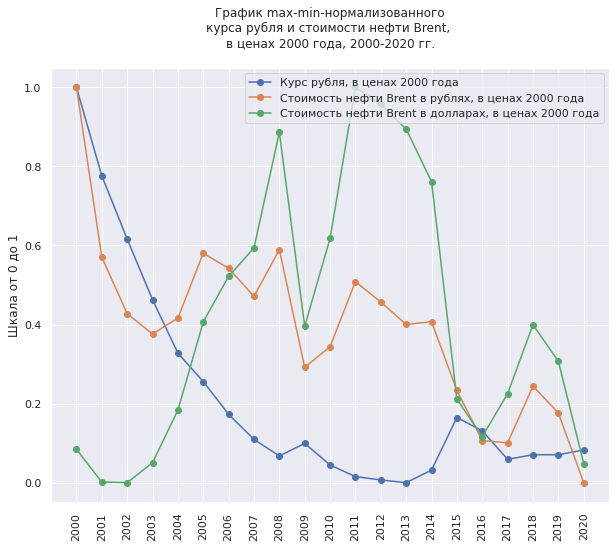

In [22]:
# Min-Max-нормализация данных -- скалирует данные к диапазону [0, 1] 
d1 = adj_df['adj_rate']
d2 = adj_df['adj_brent_rub']
d3 = adj_df['adj_brent_usd']
rates_norm = (d1 - np.min(d1))/(np.max(d1) - np.min(d1))
brent_rub_norm = (d2 - np.min(d2))/(np.max(d2) - np.min(d2))
brent_usd_norm = (d3 - np.min(d3))/(np.max(d3) - np.min(d3))

data = np.array([rates_norm, brent_rub_norm, brent_usd_norm]).T

adj_norm_df = pd.DataFrame(data=data, index=rates_brent_yearly.index)

# Построение графика
fig, ax = plt.subplots()
ax.plot(adj_norm_df, marker='o')

title = """График max-min-нормализованного
курса рубля и стоимости нефти Brent, 
в ценах 2000 года, 2000-2020 гг.
"""

ax.set_title(title)

ax.xaxis.set_tick_params(rotation=90)
ax.set_xticks(adj_norm_df.index)
ax.set_ylabel('Шкала от 0 до 1')

fig.set_size_inches(10, 8)

labels = ['Курс рубля, в ценах 2000 года',
          'Стоимость нефти Brent в рублях, в ценах 2000 года', 
          'Стоимость нефти Brent в долларах, в ценах 2000 года'
          ]
plt.legend(loc='best', labels=labels)
plt.show()

Как мне кажется, картина такая же, что и на графике, на котором НЕ учитывается инфляция, а именно -- примерно когда стоимость нефти растет, курс укрепляется (т. е. кривая курса рубля идет вниз), но видно это скорее в сравнении с кривой стоимости нефти в Brent в долларах. 

Если смотреть только на кривую курса рубля и стоимость нефти в рублях, то зависимость неочевидная, так как кривая нефти в рублях выгдядит несколько хаотичной. 

Отвечая на вопрос в задании. Курс рубля определяется нефтью? Да, по графикам выглядит, что связь между ними есть.

## График рассеяния для дневных показателей - в ценах 2000 года, без скалирования

In [23]:
# Добавление в датафрейм rate_brent с ежедневными данными колонок с учетом инфляции

# Сначала 2 словаря {год: дефлятор} для инфлияции в России и США
# переменные deflators_RUS и deflators_USD были определены ранее
deflators_RUS_dict = {2000: 1}
for year, defl in zip(range(2001, 2023, 1), deflators_RUS):
    deflators_RUS_dict[year] = defl

deflators_USD_dict = {2000: 1}
for year, defl in zip(range(2001, 2023, 1), deflators_USD):
    deflators_USD_dict[year] = defl

# Две функции, принимающие тупл (цена, год) для передачу в функцию apply
def adj_USD(price_year):
    price, year = price_year
    year = year.year
    return price * deflators_USD_dict[year]

def adj_RUS(price_year):
    price, year = price_year
    year = year.year
    return price * deflators_RUS_dict[year]

In [24]:
rates_brent['adj_rate'] = rates_brent.loc[:, ['rate', 'date']].apply(adj_RUS, axis=1)
rates_brent['adj_brent_usd'] = rates_brent.loc[:, ['price_usd', 'date']].apply(adj_USD, axis=1)
rates_brent['adj_brent_rub'] = rates_brent['adj_rate'] * rates_brent['adj_brent_usd']

rates_brent

,date,rate,price_usd,price_rub,adj_rate,adj_brent_usd,adj_brent_rub
0,2000-01-06,26.9000,23.55,633.495000,26.900000,23.550000,633.495000
1,2000-01-07,27.2300,23.35,635.820500,27.230000,23.350000,635.820500
2,2000-01-11,27.7300,23.93,663.578900,27.730000,23.930000,663.578900
3,2000-01-12,28.4400,24.62,700.192800,28.440000,24.620000,700.192800
4,2000-01-13,28.8500,24.90,718.365000,28.850000,24.900000,718.365000
...,...,...,...,...,...,...,...
4009,2020-08-21,73.7711,43.94,3241.502134,7.904025,28.298302,223.670493
4010,2020-08-25,74.4184,46.01,3423.990584,7.973379,29.631427,236.262582
4011,2020-08-26,74.5126,45.79,3411.931954,7.983471,29.489742,235.430511
4012,2020-08-27,75.5379,44.84,3387.119436,8.093325,28.877922,233.718395


In [25]:
# Осноные статистики для всех показателей 
rates_brent.describe()

,rate,price_usd,price_rub,adj_rate,adj_brent_usd,adj_brent_rub
count,4014.000000,4014.000000,4014.000000,4014.000000,4014.000000,4014.000000
mean,39.027902,63.780967,2407.689941,10.628374,48.954238,439.937371
std,15.636578,29.870982,1190.007474,6.063228,21.250921,138.554141
min,23.125500,9.120000,490.677200,5.316491,5.873476,46.987070
25%,28.534650,39.185000,1304.670025,6.788782,31.011866,344.529914
50%,30.893050,60.175000,2413.216001,7.951870,44.224873,436.848735
75%,56.647225,82.177500,3380.718571,11.607647,63.910245,507.873430
max,83.591300,143.950000,5703.037460,28.870000,114.905370,1043.548400


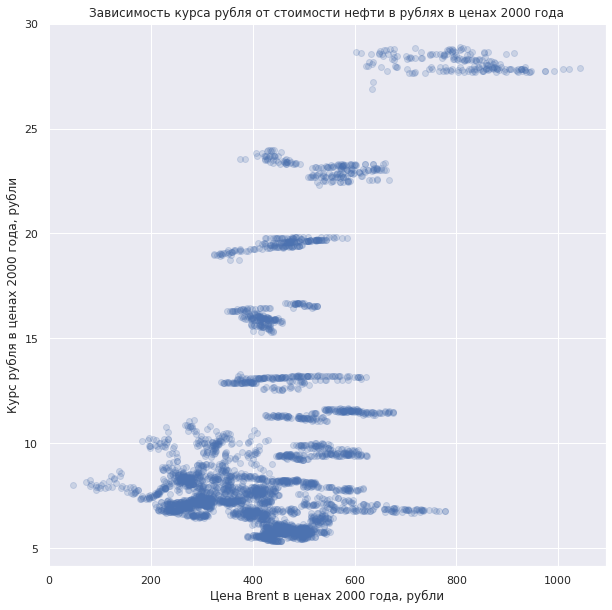

In [26]:
# Построение графика
fig, ax = plt.subplots()

ax.scatter(
    rates_brent['adj_brent_rub'],
    rates_brent['adj_rate'],
    alpha=0.2
    )

ax.set_title('Зависимость курса рубля от стоимости нефти в рублях в ценах 2000 года')
ax.set_ylabel('Курс рубля в ценах 2000 года, рубли')
ax.set_xlabel('Цена Brent в ценах 2000 года, рубли')
fig.set_size_inches(10, 10)
plt.show()

# График с ценой нефти в рублях ничего не дает, надо посмотреть в долларах

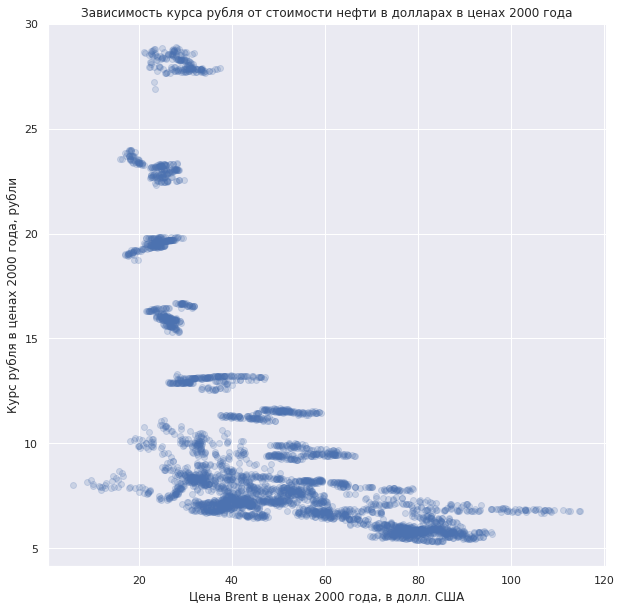

In [27]:
# График нефть-курс рубля, нефть в долларах, цены 2000 года
fig, ax = plt.subplots()

ax.scatter(
    rates_brent['adj_brent_usd'],
    rates_brent['adj_rate'],
    alpha=0.2
    )

ax.set_title('Зависимость курса рубля от стоимости нефти в долларах в ценах 2000 года')
ax.set_ylabel('Курс рубля в ценах 2000 года, рубли')
ax.set_xlabel('Цена Brent в ценах 2000 года, в долл. США')
fig.set_size_inches(10, 10)
plt.show()

Как видно из графика, рубль может укрепляться и при низкой цене на нефть. Но на части графика есть зависимость - чем дороже нефть, тем сильнее рубль

## График дневных скалированных данных, очищеных от инфляции

In [28]:
# Min-Max-нормализация данных -- скалирует данные к диапазону [0, 1] 
d1 = rates_brent['adj_rate']
d2 = rates_brent['adj_brent_rub']
d3 = rates_brent['adj_brent_usd']
rates_norm_daily = (d1 - np.min(d1))/(np.max(d1) - np.min(d1))
brent_norm_daily = (d2 - np.min(d2))/(np.max(d2) - np.min(d2))
brent_usd_norm_daily = (d3 - np.min(d3))/(np.max(d3) - np.min(d3))

# Новый датафрейм со скалированными дневными данными
data = np.array([rates_norm_daily, brent_norm_daily, brent_usd_norm_daily]).T
columns = ['norm_rub_rate', 'norm_brent_rub', 'norm_brent_usd']
norm_daily = pd.DataFrame(data=data, index=rates_brent['date'], columns=columns)

In [29]:
norm_daily.head()

,norm_rub_rate,norm_brent_rub,norm_brent_usd
date,,,
2000-01-06,0.916361,0.588532,0.162123
2000-01-07,0.930371,0.590865,0.160288
2000-01-11,0.951600,0.618719,0.165608
2000-01-12,0.981744,0.655460,0.171936
2000-01-13,0.999151,0.673695,0.174504


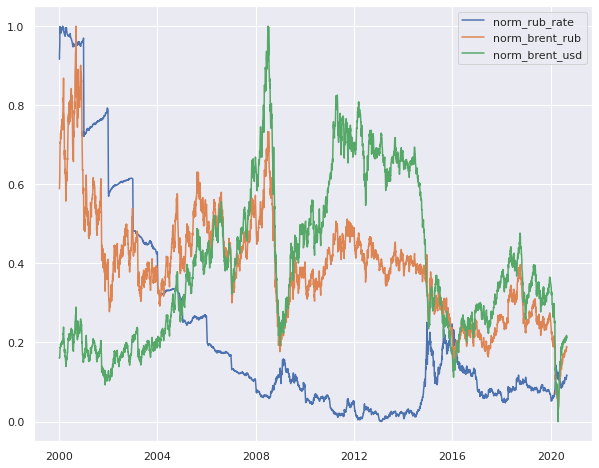

In [30]:
# График скалированных данных по дням -- чисто для интереса
fig, ax = plt.subplots()

ax.plot(norm_daily)

fig.set_size_inches(10, 8)

plt.legend(loc='best', labels=columns)
plt.show()

In [31]:
norm_daily.corr()

,norm_rub_rate,norm_brent_rub,norm_brent_usd
norm_rub_rate,1.000000,0.545807,-0.623881
norm_brent_rub,0.545807,1.000000,0.253908
norm_brent_usd,-0.623881,0.253908,1.000000
